## Life Expectancy Analysis and Forecasting

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches

# Statistical and Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind, pearsonr
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [28]:
# Define function to load and preprocess the dataset
def load_and_preprocess_data(filepath):
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Ensure correct data types
    df['Year'] = df['Year'].astype(int)
    df['Country'] = df['Country'].astype(str)
    df['Region'] = df['Region'].astype(str)
    
    # Check for missing values
    print("Missing values in each column before imputation:")
    print(df.isnull().sum())
    
    # Since the dataset is already cleaned according to the Kaggle source, we proceed
    return df

In [29]:
# Define function for feature engineering
def feature_engineering(df):
    # Combine economic status into a single variable
    df['Economic_Status'] = df.apply(
        lambda row: 'Developed' if row['Economy_status_Developed'] == 1 else 'Developing', axis=1
    )
    df.drop(['Economy_status_Developed', 'Economy_status_Developing'], axis=1, inplace=True)
    
    # Create average immunization score
    immunization_cols = ['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria']
    df['Avg_Immunization'] = df[immunization_cols].mean(axis=1)
    
    # Create mortality ratio
    df['Adult_to_Infant_Mortality_Ratio'] = df['Adult_mortality'] / (df['Infant_deaths'] + 1)
    
    # Log transformation of GDP per capita
    df['GDP_per_capita_log'] = np.log(df['GDP_per_capita'] + 1)
    
    # Combine thinness variables
    thinness_cols = ['Thinness_ten_nineteen_years', 'Thinness_five_nine_years']
    df['Thinness_children_adolescents'] = df[thinness_cols].mean(axis=1)
    
    # Combine infant and under-five deaths
    df['Child_deaths'] = df['Infant_deaths'] + df['Under_five_deaths']
    
    # Drop redundant columns
    df.drop(immunization_cols + ['GDP_per_capita'] + thinness_cols + ['Infant_deaths', 'Under_five_deaths'], axis=1, inplace=True)
    
    # One-hot encode 'Economic_Status'
    df = pd.get_dummies(df, columns=['Economic_Status'], drop_first=True)
    
    return df

In [30]:
# Define function to calculate VIFs
def calculate_vifs(df, target_variable):
    features = df.select_dtypes(include=[np.number]).columns.tolist()
    features.remove(target_variable)
    X = df[features]
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    print("\nVIF values:")
    print(vif_data)
    return vif_data

In [31]:
# Define function for exploratory data analysis
def exploratory_data_analysis(df):
    # Descriptive statistics
    print(df.describe())
    
    # Distribution of Life Expectancy
    plt.figure(figsize=(10,6))
    sns.histplot(df['Life_expectancy'], bins=30, kde=True)
    plt.title('Distribution of Life Expectancy')
    plt.xlabel('Life Expectancy')
    plt.ylabel('Frequency')
    plt.show()
    
    # Life Expectancy Over Years
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x='Year', y='Life_expectancy', ci=None)
    plt.title('Average Life Expectancy Over Years')
    plt.xlabel('Year')
    plt.ylabel('Life Expectancy')
    plt.show()
    
    # Life Expectancy by Economic Status
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Economic_Status_Developing', y='Life_expectancy', data=df)
    plt.title('Life Expectancy by Economic Status')
    plt.xlabel('Economic Status (1=Developing, 0=Developed)')
    plt.ylabel('Life Expectancy')
    plt.show()
    
    # Correlation Matrix
    plt.figure(figsize=(16,12))
    numeric_df = df.select_dtypes(include=[np.number]) 
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

In [32]:
# Define function for regression analysis
def regression_analysis(df):
    # Define target and features
    X = df.drop(['Life_expectancy', 'Country', 'Region'], axis=1)
    y = df['Life_expectancy']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Multiple Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Coefficients
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lr.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    print("Linear Regression Coefficients:")
    print(coefficients)
    
    # Evaluation
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print('\nLinear Regression RMSE:', rmse)
    print('Linear Regression R^2:', r2)
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)
    print('\nRidge Regression RMSE:', rmse_ridge)
    print('Ridge Regression R^2:', r2_ridge)
    
    # Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2_lasso = r2_score(y_test, y_pred_lasso)
    print('\nLasso Regression RMSE:', rmse_lasso)
    print('Lasso Regression R^2:', r2_lasso)
    
    return lr, ridge, lasso

In [33]:
# Define function for classification analysis
def classification_analysis(df):
    # Prepare data
    X_cls = df.drop(['Economic_Status_Developing', 'Country', 'Region'], axis=1)
    y_cls = df['Economic_Status_Developing']
    
    # Split data
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train_cls, y_train_cls)
    y_pred_cls = logreg.predict(X_test_cls)
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test_cls, y_pred_cls))
    
    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_cls, y_train_cls)
    y_pred_rf = rf.predict(X_test_cls)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test_cls, y_pred_rf))
    
    # Feature Importances
    importances = rf.feature_importances_
    feature_names = X_train_cls.columns
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print("\nRandom Forest Feature Importances:")
    print(feature_importances)
    
    return logreg, rf

In [34]:
# Define function for time series forecasting using ARIMA
def arima_forecasting(df, country_name, start_year=2016, end_year=2040):
    country_data = df[df['Country'] == country_name].groupby('Year')['Life_expectancy'].mean()
    forecast_years = list(range(start_year, end_year + 1))
    
    try:
        arima_model = ARIMA(country_data, order=(3, 1, 0))
        arima_results = arima_model.fit()
        forecast = arima_results.get_forecast(steps=len(forecast_years))
        forecast_values = forecast.predicted_mean
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(country_data.index, country_data.values, label="Historical Data", color="blue", marker='o')
        plt.plot(forecast_years, forecast_values, label="Forecasted Data", color="orange", linestyle='--', marker='x')
        plt.title(f"Life Expectancy Forecast for {country_name}")
        plt.xlabel("Year")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.grid()
        plt.show()
        
    except Exception as e:
        print(f"ARIMA model failed for {country_name}: {e}")

In [35]:
# Define function for time series forecasting using XGBoost
def xgboost_forecasting(df, country_name, lag=9, start_year=2016, end_year=2040):
    # Prepare data with lag features
    data = df.copy()
    features = []
    for i in range(1, lag + 1):
        data[f"Lag_{i}"] = data.groupby('Country')['Life_expectancy'].shift(i)
        features.append(f"Lag_{i}")
    data = data.dropna().reset_index(drop=True)
    
    # Prepare dataset
    X = data[features]
    y = data['Life_expectancy']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Train XGBoost model
    xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Forecasting
    country_data = df[df['Country'] == country_name].sort_values('Year')
    last_values = country_data.tail(lag)['Life_expectancy'].values.tolist()
    forecasts = []
    for _ in range(start_year, end_year + 1):
        input_data = np.array(last_values[-lag:]).reshape(1, -1)
        pred = xgb_model.predict(input_data)[0]
        forecasts.append(pred)
        last_values.append(pred)
    
    # Plotting
    forecast_years = list(range(start_year, end_year + 1))
    historical_data = country_data[country_data['Year'] < start_year]
    plt.figure(figsize=(10, 6))
    plt.plot(historical_data['Year'], historical_data['Life_expectancy'], label="Historical Data", color="blue", marker='o')
    plt.plot(forecast_years, forecasts, label="Forecasted Data", color="orange", linestyle='--', marker='x')
    plt.title(f"Life Expectancy Forecast for {country_name}")
    plt.xlabel("Year")
    plt.ylabel("Life Expectancy")
    plt.legend()
    plt.grid()
    plt.show()

In [49]:
# Define function for clustering analysis
def clustering_analysis(df):
    X = df.drop(['Life_expectancy', 'Country', 'Region'], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(X_scaled)
    df['Cluster'] = clusters

    # Map cluster numbers to labels
    cluster_labels = {2: 'Developed', 1: 'Developing', 0: 'Emerging'}
    df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

    # Define the color palette based on the labels
    color_map = {'Developed': 'blue', 'Developing': 'green', 'Emerging': 'orange'}

    # Plot clusters with the specified color palette
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_Label'], palette=color_map, s=100)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Country Clustering")
    plt.legend(title='Cluster Label')
    plt.show()
    
    # Load world shapefile
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    country_mapping = {'United States': 'United States of America'}
    df['Country'] = df['Country'].map(country_mapping).fillna(df['Country'])

    # Merge world map with your data (assuming 'df' has 'Country' and 'Cluster_Label' columns)
    world = world.merge(df[['Country', 'Cluster_Label']], left_on='name', right_on='Country', how='left')

    # Check for missing values and fill them with 'Unknown' (or any other label you prefer)
    world['Cluster_Label'].fillna('Unknown', inplace=True)

    # Set up a color palette based on the 'Cluster_Label'
    color_map = {'Developed': 'blue', 'Developing': 'green', 'Emerging': 'orange', 'Unknown': 'gray'}

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.plot(ax=ax, color=world['Cluster_Label'].map(color_map), edgecolor='black', legend=False)

    # Add the legend manually
    handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
    ax.legend(handles=handles, title="Cluster Label", fontsize=12)

    # Add title
    ax.set_title("Country Clusters by Development Status", fontsize=15)

    # Show the plot
    plt.show()
    
    return df

In [44]:
# Define main function to run all analyses
def main():
    # Load and preprocess data
    df = load_and_preprocess_data('Life-Expectancy-Data-Updated.csv')
    
    # Feature engineering
    df = feature_engineering(df)
    
    # Calculate VIFs
    vif_data = calculate_vifs(df, 'Life_expectancy')
    
    # Save the cleaned and prepared dataset
    df.to_csv('Cleaned_Life_Expectancy_Data.csv', index=False)
    print("\nData cleaning and feature engineering complete. Cleaned data saved to 'Cleaned_Life_Expectancy_Data.csv'.")
    
    # Exploratory Data Analysis
    exploratory_data_analysis(df)
    
    # Regression Analysis
    regression_models = regression_analysis(df)
    
    # Classification Analysis
    classification_models = classification_analysis(df)
    
    # ARIMA Forecasting
    arima_forecasting(df, country_name='Argentina')
    arima_forecasting(df, country_name='United States')
    
    # XGBoost Forecasting
    xgboost_forecasting(df, country_name='Argentina')
    xgboost_forecasting(df, country_name='United States')
    
    # Clustering Analysis
    df_clustered = clustering_analysis(df)
    
    # Additional statistical tests
    # Pearson Correlation
    correlation, _ = pearsonr(df['Child_deaths'], df['Life_expectancy'])
    print(f"\nPearson Correlation between Child Deaths and Life Expectancy: {correlation:.4f}")
    
    # t-test between Developed and Developing countries
    developed = df[df['Economic_Status_Developing'] == 0]['Life_expectancy']
    developing = df[df['Economic_Status_Developing'] == 1]['Life_expectancy']
    t_stat, p_value = ttest_ind(developed, developing)
    print(f"\nt-test between Developed and Developing countries: t={t_stat:.4f}, p={p_value:.4f}")

Missing values in each column before imputation:
Country                        0
Region                         0
Year                           0
Infant_deaths                  0
Under_five_deaths              0
Adult_mortality                0
Alcohol_consumption            0
Hepatitis_B                    0
Measles                        0
BMI                            0
Polio                          0
Diphtheria                     0
Incidents_HIV                  0
GDP_per_capita                 0
Population_mln                 0
Thinness_ten_nineteen_years    0
Thinness_five_nine_years       0
Schooling                      0
Economy_status_Developed       0
Economy_status_Developing      0
Life_expectancy                0
dtype: int64

VIF values:
                            Feature         VIF
0                              Year  637.956691
1                   Adult_mortality   33.011965
2               Alcohol_consumption    6.165329
3                               BMI  345

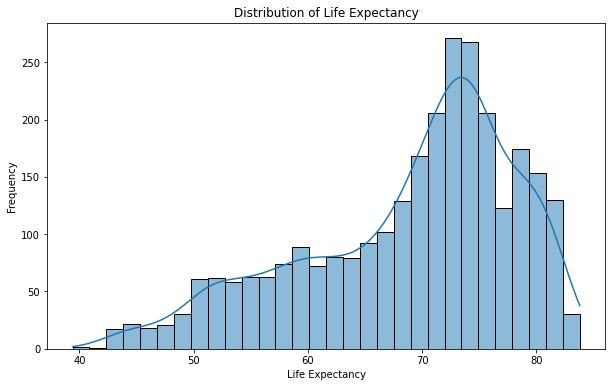

/tmp/ipykernel_94943/1907072108.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Life_expectancy', ci=None)


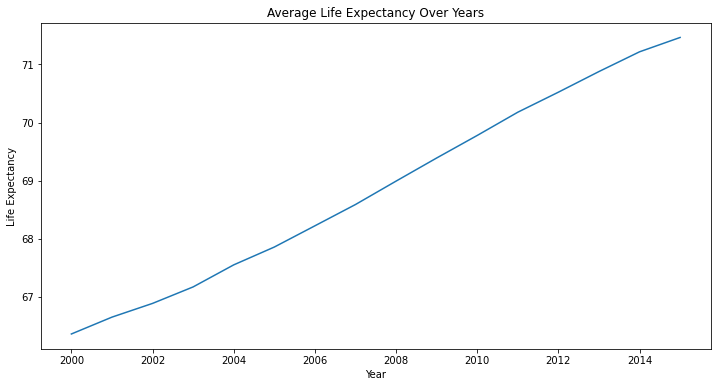

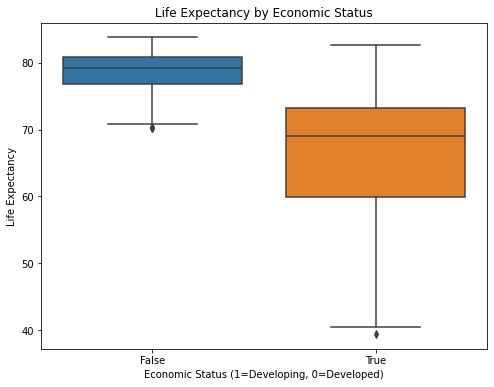

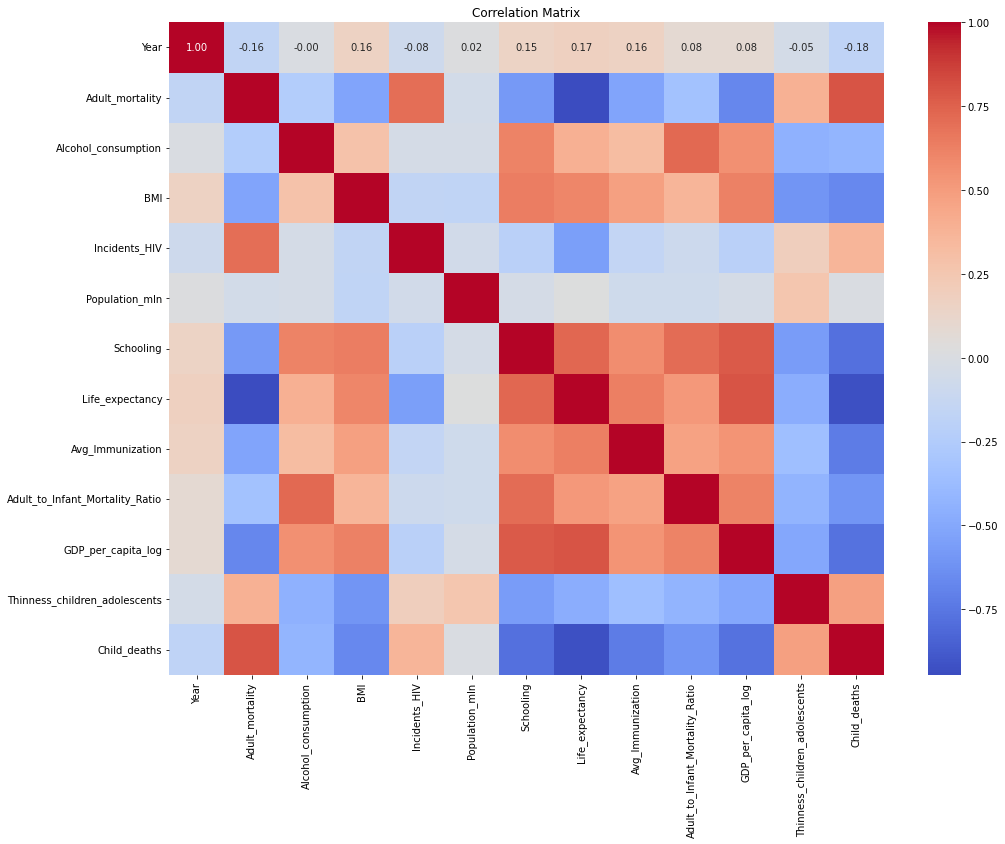

Linear Regression Coefficients:
                            Feature  Coefficient
12       Economic_Status_Developing    -0.873568
9                GDP_per_capita_log     0.519760
3                               BMI    -0.206184
6                         Schooling     0.093267
11                     Child_deaths    -0.050934
2               Alcohol_consumption     0.050277
4                     Incidents_HIV     0.048242
1                   Adult_mortality    -0.046538
10    Thinness_children_adolescents    -0.040517
0                              Year     0.025723
8   Adult_to_Infant_Mortality_Ratio    -0.019084
7                  Avg_Immunization    -0.002832
5                    Population_mln    -0.000187

Linear Regression RMSE: 1.352107229826833
Linear Regression R^2: 0.9779712321699875

Ridge Regression RMSE: 1.3520529962255088
Ridge Regression R^2: 0.9779729993012118

Lasso Regression RMSE: 1.3692782349224906
Lasso Regression R^2: 0.9774081734176151


/home/mixmaster01/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.91      0.92       118
        True       0.98      0.98      0.98       455

    accuracy                           0.97       573
   macro avg       0.96      0.95      0.95       573
weighted avg       0.97      0.97      0.97       573


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       118
        True       1.00      1.00      1.00       455

    accuracy                           1.00       573
   macro avg       1.00      1.00      1.00       573
weighted avg       1.00      1.00      1.00       573


Random Forest Feature Importances:
                            Feature  Importance
12                     Child_deaths    0.202899
7                   Life_expectancy    0.168603
9   Adult_to_Infant_Mortality_Ratio    0.136292
10               GDP_per_capita_log 

/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

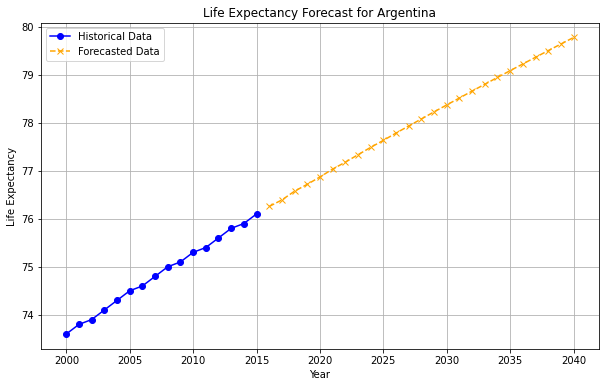

/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/mixmaster01/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

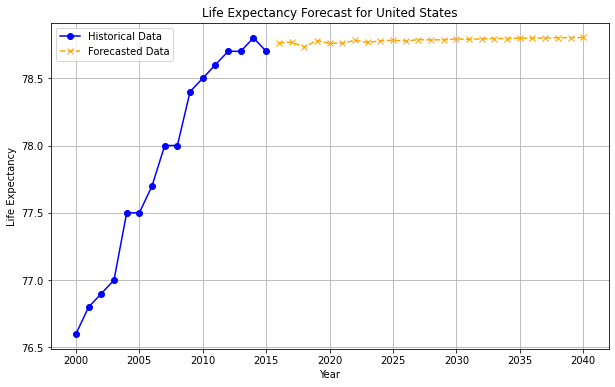

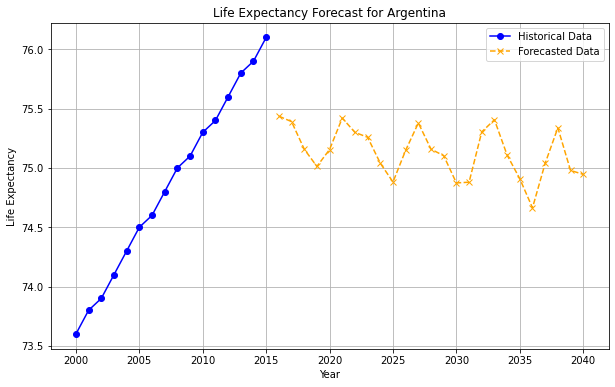

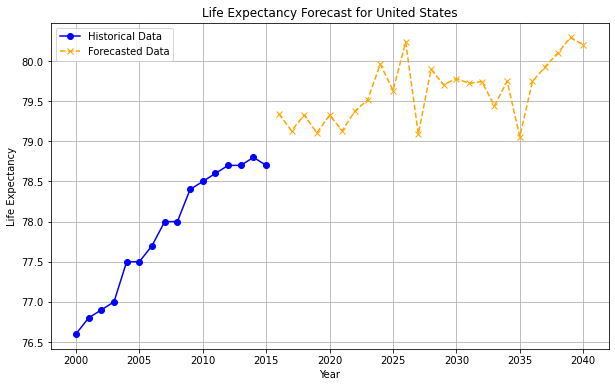

/home/mixmaster01/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


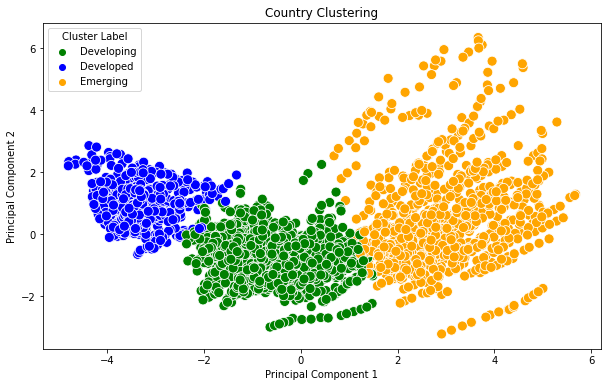

/tmp/ipykernel_94943/3270324882.py:33: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


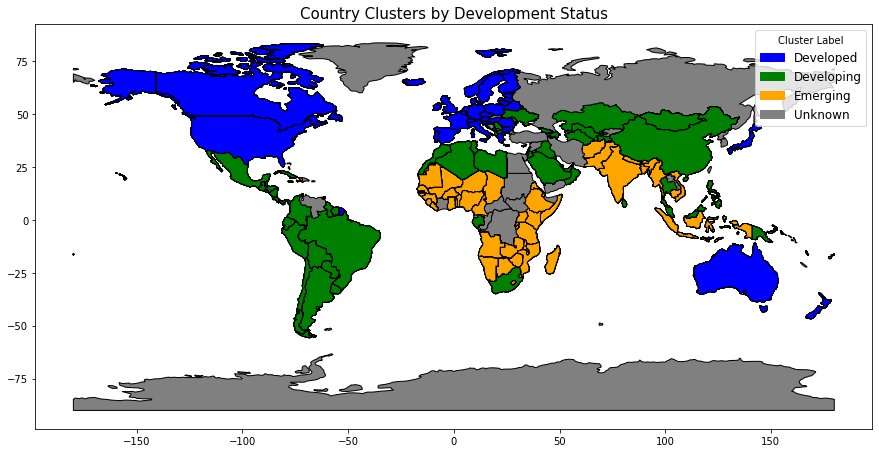


Pearson Correlation between Child Deaths and Life Expectancy: -0.9234

t-test between Developed and Developing countries: t=32.8951, p=0.0000


In [50]:
# Run the main function
if __name__ == "__main__":
    main()